In [8]:
import matplotlib 
from scholte import *
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt
import numpy as np

In [9]:
kobs,fobs=load_dispersion_observations()

In [10]:
def plt_dispersion(f,k,fobs,kobs,z,vs,save=False):

    fig,ax=plt.subplots(1,2,figsize=(16,9))
    fig.patch.set_facecolor('w')
    plt.subplot(121)
    plt.step(vs,z,label='Vs (km/s)')
    # plt.step(p,z,label='Vp (km/s)')
    # plt.step(rho,z,'--',label='Density (kg/m**3)')
    plt.ylim([max(z),0])

    plt.grid()
    # plt.legend(fontsize=18)
    plt.ylabel('Depth (m)',fontsize=22)
    plt.xlabel('Shear Wave Speed (m/s)',fontsize=22)
    
#     plt.text(0.1,50,'water',fontsize=18)
#     plt.text(100,120,'fluidized \nsediments',fontsize=18)
#     plt.text(400,175,'   compact \n sediments',fontsize=18)

    plt.xlim([-10, 650])

    plt.subplot(122)
    ind = 0
    for kk,ff in zip(k,f):
        plt.plot(kk,ff,'-',label=f'Model Mode {ind}',markersize=12,c=f'C{ind}')
        ind = ind+1
    ind = 0
    for kk,ff in zip(kobs,fobs):
        plt.plot( kk , ff, 'o' , label=f'Obs. Mode {ind}',markersize=10,c=f'C{ind}')
        ind = ind+1
    plt.ylabel('Frequency (Hz)',fontsize=22)
    plt.xlabel(r'Ordinary Wavenumber, $1/\lambda$ (1/m)',fontsize=22)

    
#     fit = linregress(kobs,fobs)
#     plt.plot(kobs, fit.slope*kobs + fit.intercept,'--',label=f'Constant vg ({fit.slope:.0f} m/s)')
#     print(fit.slope)
#     print(fit.intercept)
    plt.legend(fontsize=18)
    plt.grid()
    if save:
        plt.savefig('model.eps')
    else:
        plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


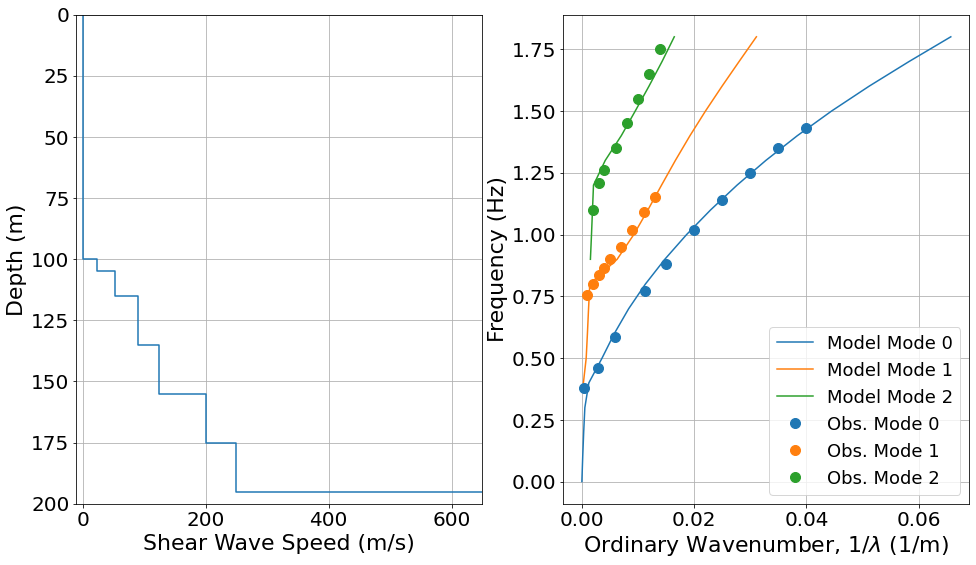

In [29]:
h =  [0.100, 0.005, 0.010, 0.02, 0.02, 0.02, 0.02, 0.0]
# vs = [0, 0.025,           0.050,           0.090,          0.1, 
#       0.2, 0.2, 1.00]
vs = np.array([0, 0.0233, 0.0522, 0.0906, 0.125 , 0.20 , 0.25, 1.5])
vp = np.ones_like(vs) * 1.6
vp[0]=1.5
rho = np.ones_like(vs) * 1.5
rho[0]=1

f,k = pysurf96(h,vp,vs,rho)

plt_dispersion(f,k,fobs,kobs,
               np.hstack([0,np.cumsum(h)*1e3,200]),
               1000*np.hstack([vs,vs[-1],vs[-1]]),
              save=True)

In [5]:
# Four layer model -- tuned for one mode!
# h =  [0.100, 0.005, 0.010, 0.025, 0.0]
# vs = [0, 0.038, 0.043, 0.080, 0.600]
# vp = [1.5,1.6,1.6,1.6,1.6]
# rho= [1,1.5,1.5,1.5,1.5]

# Three-layer model
# h =  [0.100, 0.005, 0.035, 0.0]
# vs = [0, 0.024, 0.06,  15.00]
# vp = [1.5,1.6,1.6,16.0]
# rho= [1,1.5,1.5,1.5]